# Load CSV files to Pandas DataFrame

In [1]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import seaborn as sns

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


538    image_id label  image_width  image_height  is_tma
0         4  HGSC        23785         20008   False
1        66  LGSC        48871         48195   False
2        91  HGSC         3388          3388    True
3       281  LGSC        42309         15545   False
4       286    EC        37204         30020   False


1    image_id  image_width  image_height
0        41        28469         16987
label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64


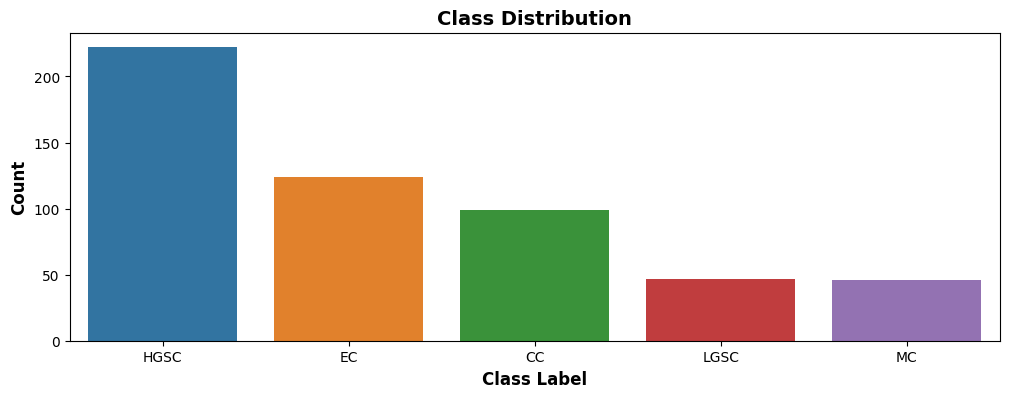

In [2]:
train_csv_path = "/kaggle/input/UBC-OCEAN/train.csv"
test_csv_path = "/kaggle/input/UBC-OCEAN/test.csv"
train_pandas_df = pd.read_csv(train_csv_path)
test_pandas_df = pd.read_csv(test_csv_path)
BASE_DIR = ["/kaggle/input/UBC-OCEAN/train_thumbnails/", "/kaggle/input/UBC-OCEAN/test_thumbnails/"]
print(len(train_pandas_df), train_pandas_df.head())
print("\n")
print(len(test_pandas_df), test_pandas_df.head())
class_distribution = train_pandas_df['label'].value_counts()
print(class_distribution)
plt.figure(figsize=(12, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class Label', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.show()

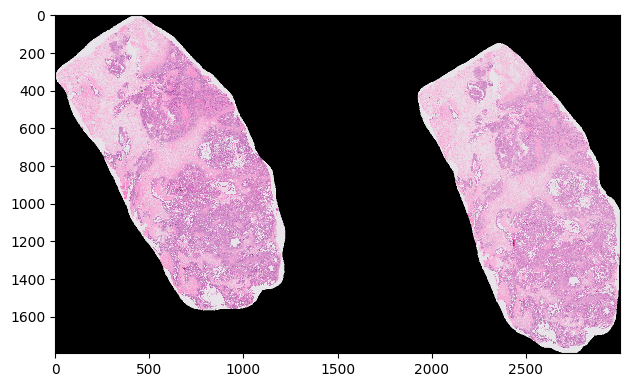

In [3]:
from skimage import io
io.imshow('/kaggle/input/UBC-OCEAN/train_thumbnails/10642_thumbnail.png')

Data Preparation: Preprocess and create data loaders for the dataset.

Model Definition: Define the EfficientNet model.

Training: Train the model on the training data.

Evaluation: Evaluate the model on the test data and generate predictions.

Submission: Prepare the submission file format.m

---
# Questions:

Is there any preference for data augmentation or preprocessing techniques?
No preference.

Should I consider using any pre-trained weights for the EfficientNet model?
Yes, use pretrained weights.

How many epochs should the model be trained for, and do you have any specific hyperparameters in mind?
Optimize the hyperparameters later, set the hyperparameters to default.

Is there any validation strategy you'd like to employ (e.g., k-fold cross-validation, train-validation split)?
k-fold cross-validation for now.

Given the limitations of this environment, we may need to adjust the depth of the model, reduce the batch size, or make other adjustments to ensure the model trains within a reasonable time frame. Would that be acceptable?
Yes, it is acceptable.

---
# Data Visualization:

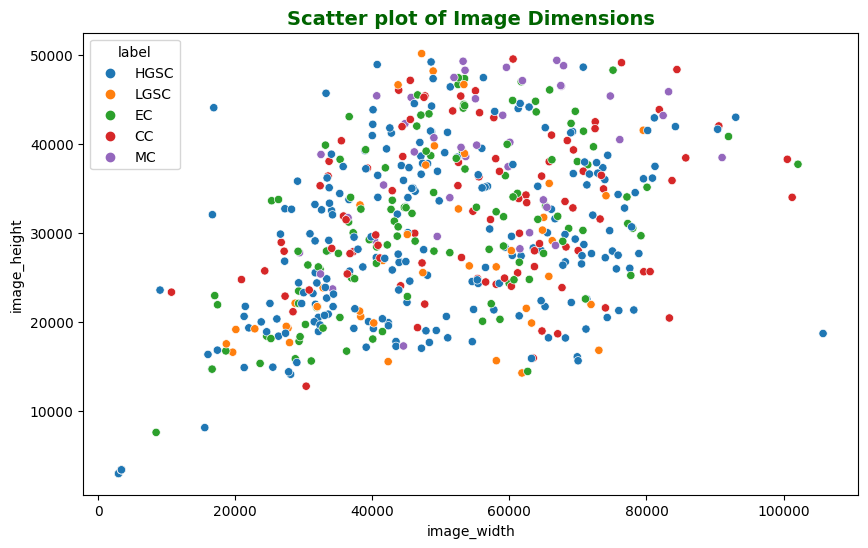

In [4]:

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='image_width', y='image_height', data=train_pandas_df, hue='label')
plt.title('Scatter plot of Image Dimensions', fontsize = 14, fontweight = 'bold', color = 'darkgreen')
plt.savefig('Scatter plot of Image Dimensions.png')
plt.show()

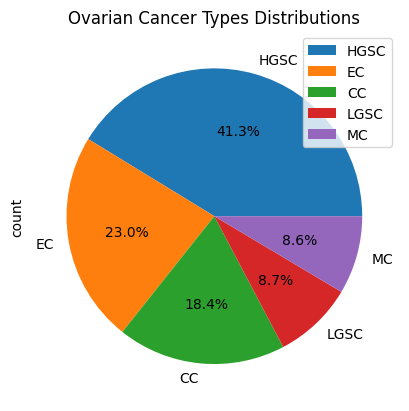

In [5]:
train_pandas_df['label'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("Ovarian Cancer Types Distributions")
plt.legend()
plt.show()

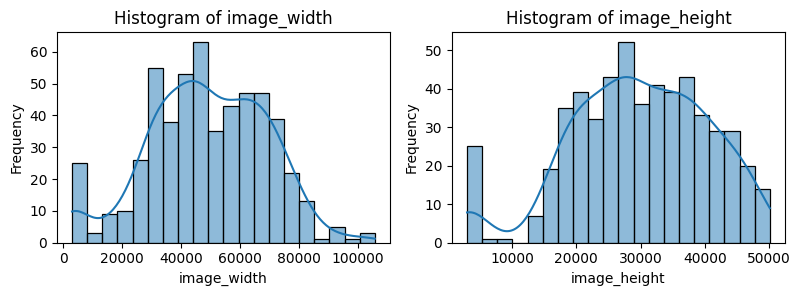

In [6]:
# Select numerical features for the histogram
numerical_features = ['image_width', 'image_height']

# Set up the figure and axis
plt.figure(figsize=(12, 8))

# Create histograms for each numerical feature
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)  # Create a grid of 3x3 plots
    sns.histplot(train_pandas_df[feature], bins=20, kde=True)  # Create the histogram
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

              image_width  image_height
image_width      1.000000      0.524395
image_height     0.524395      1.000000


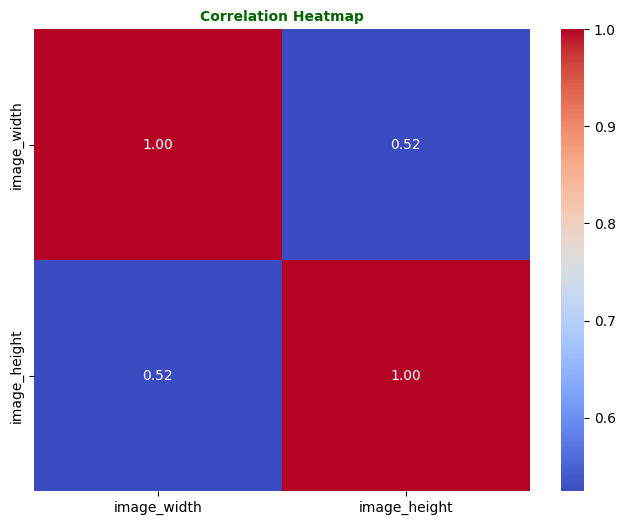

In [7]:
# Correlation between Image Dimensions
correlation = train_pandas_df[['image_width', 'image_height']].corr()
print(correlation)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap', fontsize = 10, fontweight = 'bold', color = 'darkgreen')
plt.show()

In [8]:

CONFIG = {
    "seed": 42,
    "epochs": 40,
    "img_size": 512,# 512
    "model_name": "tf_efficientnet_b0_ns",
    "num_classes": 5,
    "train_batch_size": 16,# 32
    "valid_batch_size": 64,
    "learning_rate": 3e-4,#1e-4
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-6, # 1e-6
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 7,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
ROOT_DIR = '/kaggle/input/UBC-OCEAN'
TRAIN_DIR = '/kaggle/input/UBC-OCEAN/train_thumbnails'
TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'
ALT_TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'

In [11]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}_thumbnail.png"
#    return f"{TRAIN_DIR}/{image_id}.png"

In [12]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.png"))

In [13]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['image_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

,image_id,label,image_width,image_height,is_tma,file_path
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...
2,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...
3,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...
4,431,HGSC,39991,40943,False,/kaggle/input/UBC-OCEAN/train_thumbnails/431_t...
...,...,...,...,...,...,...
508,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65022...
509,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65094...
510,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65300...
511,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65371...


In [14]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

with open("label_encoder.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

In [15]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

1099

---
# K-fold
With the model defined, let's move on to the Training step.

For training, I'll use k-fold cross-validation as suggested. During each fold, we'll train the model using the training split and evaluate its performance on the validation split.

In [16]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.label)):
      df.loc[val_ , "kfold"] = int(fold)

# Dataset Class

In [17]:
class UBCDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

# Data Augmentations (transforms)

In [18]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# GeM Pooling

In [19]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# Create EfficientNet_b0 Model

In [20]:
class UBCModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True, checkpoint_path=None):
        super(UBCModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        return output

    
model = UBCModel(CONFIG['model_name'], CONFIG['num_classes'])#, checkpoint_path=CONFIG['checkpoint_path']
model.to(CONFIG['device'])

UBCModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 

# Loss Function

In [21]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

# Model Training

In [22]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )
        
        running_loss += (loss.item() * batch_size)
        running_acc  += acc.item()
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Acc=epoch_acc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_acc

In [23]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )

        running_loss += (loss.item() * batch_size)
        running_acc  += acc.item()
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Acc=epoch_acc,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss, epoch_acc

In [24]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_acc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_acc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_acc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train Accuracy'].append(train_epoch_acc)
        history['Valid Accuracy'].append(val_epoch_acc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_acc <= val_epoch_acc:
            print(f"{b_}Validation Accuracy Improved ({best_epoch_acc} ---> {val_epoch_acc})")
            best_epoch_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Acc{:.2f}_Loss{:.4f}_epoch{:.0f}.bin".format(best_epoch_acc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Accuracy: {:.4f}".format(best_epoch_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [25]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [26]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = UBCDataset(df_train, transforms=data_transforms["train"])
    valid_dataset = UBCDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [27]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])

In [28]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

In [29]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 2/2 [00:13<00:00,  6.53s/it, Epoch=1, LR=0.0003, Valid_Acc=0.446, Valid_Loss=1.33]


Validation Accuracy Improved (-inf ---> 0.44594594594594594)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.63s/it, Epoch=2, LR=0.000298, Valid_Acc=0.541, Valid_Loss=1.11]


Validation Accuracy Improved (0.44594594594594594 ---> 0.5405405405405406)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.68s/it, Epoch=3, LR=0.000296, Valid_Acc=0.635, Valid_Loss=1.06]


Validation Accuracy Improved (0.5405405405405406 ---> 0.6351351351351351)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.59s/it, Epoch=4, LR=0.000293, Valid_Acc=0.662, Valid_Loss=0.944]


Validation Accuracy Improved (0.6351351351351351 ---> 0.6621621621621622)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.66s/it, Epoch=5, LR=0.000289, Valid_Acc=0.649, Valid_Loss=1.14]


100%|██████████| 2/2 [00:11<00:00,  5.64s/it, Epoch=6, LR=0.000284, Valid_Acc=0.689, Valid_Loss=1.06]


Validation Accuracy Improved (0.6621621621621622 ---> 0.6891891891891891)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.67s/it, Epoch=7, LR=0.000279, Valid_Acc=0.689, Valid_Loss=1.14]


Validation Accuracy Improved (0.6891891891891891 ---> 0.6891891891891891)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.61s/it, Epoch=8, LR=0.000273, Valid_Acc=0.622, Valid_Loss=1.15]


100%|██████████| 2/2 [00:11<00:00,  5.57s/it, Epoch=9, LR=0.000266, Valid_Acc=0.649, Valid_Loss=1.5] 


100%|██████████| 2/2 [00:11<00:00,  5.60s/it, Epoch=10, LR=0.000258, Valid_Acc=0.622, Valid_Loss=1.44]


100%|██████████| 2/2 [00:11<00:00,  5.61s/it, Epoch=11, LR=0.00025, Valid_Acc=0.649, Valid_Loss=1.17]


100%|██████████| 2/2 [00:11<00:00,  5.56s/it, Epoch=12, LR=0.000241, Valid_Acc=0.635, Valid_Loss=1.38]


100%|██████████| 2/2 [00:11<00:00,  5.65s/it, Epoch=13, LR=0.000232, Valid_Acc=0.662, Valid_Loss=1.3] 


100%|██████████| 2/2 [00:11<00:00,  5.66s/it, Epoch=14, LR=0.000222, Valid_Acc=0.676, Valid_Loss=1.41]


100%|██████████| 2/2 [00:11<00:00,  5.60s/it, Epoch=15, LR=0.000212, Valid_Acc=0.635, Valid_Loss=1.38]


100%|██████████| 2/2 [00:11<00:00,  5.64s/it, Epoch=16, LR=0.000201, Valid_Acc=0.689, Valid_Loss=1.14]


Validation Accuracy Improved (0.6891891891891891 ---> 0.6891891891891891)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.58s/it, Epoch=17, LR=0.00019, Valid_Acc=0.622, Valid_Loss=1.58]


100%|██████████| 2/2 [00:11<00:00,  5.63s/it, Epoch=18, LR=0.000179, Valid_Acc=0.635, Valid_Loss=1.46]


100%|██████████| 2/2 [00:11<00:00,  5.80s/it, Epoch=19, LR=0.000168, Valid_Acc=0.703, Valid_Loss=1.28]


Validation Accuracy Improved (0.6891891891891891 ---> 0.7027027027027027)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.59s/it, Epoch=20, LR=0.000157, Valid_Acc=0.676, Valid_Loss=1.29]


100%|██████████| 2/2 [00:11<00:00,  5.66s/it, Epoch=21, LR=0.000145, Valid_Acc=0.662, Valid_Loss=1.41]


100%|██████████| 2/2 [00:11<00:00,  5.61s/it, Epoch=22, LR=0.000134, Valid_Acc=0.635, Valid_Loss=1.35]


100%|██████████| 2/2 [00:11<00:00,  5.69s/it, Epoch=23, LR=0.000123, Valid_Acc=0.662, Valid_Loss=1.51]


100%|██████████| 2/2 [00:11<00:00,  5.60s/it, Epoch=24, LR=0.000112, Valid_Acc=0.676, Valid_Loss=1.39]


100%|██████████| 2/2 [00:11<00:00,  5.62s/it, Epoch=25, LR=0.000101, Valid_Acc=0.703, Valid_Loss=1.42]


Validation Accuracy Improved (0.7027027027027027 ---> 0.7027027027027027)
Model Saved



100%|██████████| 2/2 [00:11<00:00,  5.65s/it, Epoch=26, LR=9.02e-5, Valid_Acc=0.662, Valid_Loss=1.47]


100%|██████████| 2/2 [00:11<00:00,  5.60s/it, Epoch=27, LR=8.01e-5, Valid_Acc=0.649, Valid_Loss=1.5] 


100%|██████████| 2/2 [00:11<00:00,  5.58s/it, Epoch=28, LR=7.04e-5, Valid_Acc=0.662, Valid_Loss=1.43]


100%|██████████| 2/2 [00:11<00:00,  5.63s/it, Epoch=29, LR=6.12e-5, Valid_Acc=0.662, Valid_Loss=1.45]


100%|██████████| 2/2 [00:11<00:00,  5.58s/it, Epoch=30, LR=5.25e-5, Valid_Acc=0.649, Valid_Loss=1.43]


100%|██████████| 2/2 [00:11<00:00,  5.60s/it, Epoch=31, LR=4.45e-5, Valid_Acc=0.662, Valid_Loss=1.55]


100%|██████████| 2/2 [00:11<00:00,  5.62s/it, Epoch=32, LR=3.7e-5, Valid_Acc=0.689, Valid_Loss=1.5] 


100%|██████████| 2/2 [00:11<00:00,  5.63s/it, Epoch=33, LR=3.03e-5, Valid_Acc=0.676, Valid_Loss=1.5] 


100%|██████████| 2/2 [00:11<00:00,  5.58s/it, Epoch=34, LR=2.43e-5, Valid_Acc=0.676, Valid_Loss=1.49]


100%|██████████| 2/2 [00:11<00:00,  5.61s/it, Epoch=35, LR=1.91e-5, Valid_Acc=0.689, Valid_Loss=1.41]


100%|██████████| 2/2 [00:11<00:00,  5.56s/it, Epoch=36, LR=1.46e-5, Valid_Acc=0.676, Valid_Loss=1.39]


100%|██████████| 2/2 [00:11<00:00,  5.63s/it, Epoch=37, LR=1.1e-5, Valid_Acc=0.635, Valid_Loss=1.47]


100%|██████████| 2/2 [00:11<00:00,  5.63s/it, Epoch=38, LR=8.2e-6, Valid_Acc=0.662, Valid_Loss=1.48]


100%|██████████| 2/2 [00:11<00:00,  5.57s/it, Epoch=39, LR=6.27e-6, Valid_Acc=0.649, Valid_Loss=1.43]


100%|██████████| 2/2 [00:11<00:00,  5.62s/it, Epoch=40, LR=5.22e-6, Valid_Acc=0.662, Valid_Loss=1.48]



Training complete in 0h 35m 55s
Best Accuracy: 0.7027


In [30]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

In [31]:
history

,Train Loss,Valid Loss,Train Accuracy,Valid Accuracy,lr
0,1.450181,1.332820,0.402778,0.445946,0.000300
1,1.092789,1.113548,0.557870,0.540541,0.000298
2,0.845948,1.059163,0.685185,0.635135,0.000296
3,0.658575,0.943704,0.754630,0.662162,0.000293
4,0.531486,1.135869,0.798611,0.648649,0.000289
5,0.387507,1.058799,0.879630,0.689189,0.000284
6,0.367559,1.137260,0.863426,0.689189,0.000279
7,0.335381,1.149826,0.879630,0.621622,0.000273
8,0.276733,1.495439,0.893519,0.648649,0.000266
9,0.200100,1.440689,0.925926,0.621622,0.000258


# Loss, Accuracy and Learning Rate

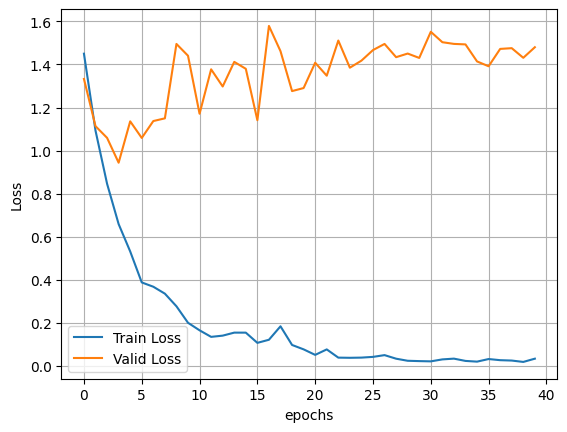

In [32]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

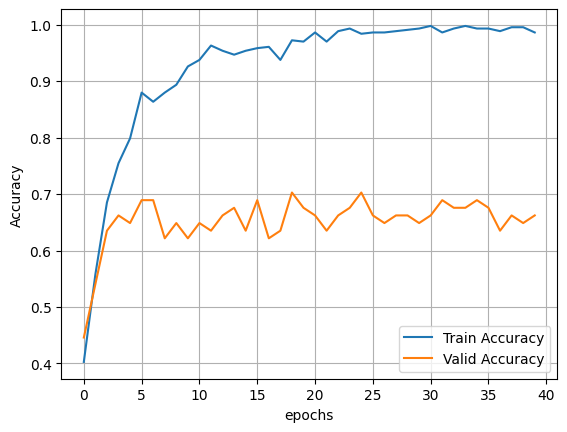

In [33]:
plt.plot( range(history.shape[0]), history["Train Accuracy"].values, label="Train Accuracy")
plt.plot( range(history.shape[0]), history["Valid Accuracy"].values, label="Valid Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

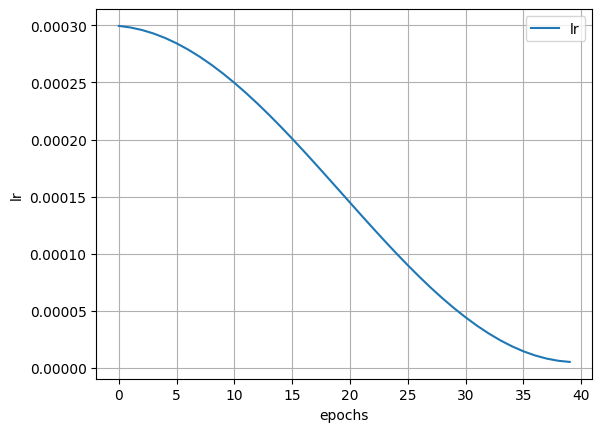

In [34]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()

# Test Data

In [35]:
# Examine the Data Split of training and testing data
train_data = glob.glob('/kaggle/input/UBC-OCEAN/train_images/*.png')
test_data = glob.glob('/kaggle/input/UBC-OCEAN/test_images/*.png')

print(f"The Training Set contains: {len(train_data)} images")
print(f"The Testing Set contains: {len(test_data)} images")

The Training Set contains: 538 images
The Testing Set contains: 1 images


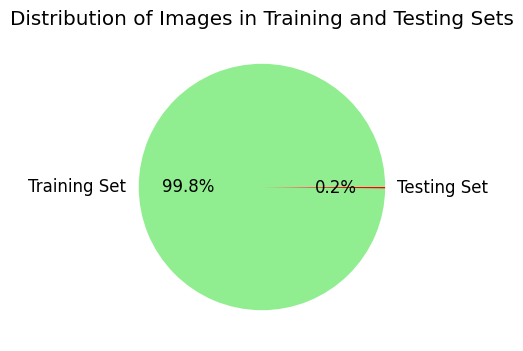

In [36]:
# Calculate total counts
total_train = len(train_data)
total_test = len(test_data)

# Set the figure size
plt.figure(figsize=(4, 4))

# Set the font size
plt.rcParams['font.size'] = 12

# Set the colors
colors = ['lightgreen', 'red']

# Plot the pie chart for the total set
plt.pie([total_train, total_test], labels=['Training Set', 'Testing Set'], autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Images in Training and Testing Sets')

# Show the plot
plt.show()

In [37]:
def get_test_file_path(image_id):
    if os.path.exists(f"{TEST_DIR}/{image_id}_thumbnail.png"):
        return f"{TEST_DIR}/{image_id}_thumbnail.png"
    else:
        return f"{ALT_TEST_DIR}/{image_id}.png"

In [38]:
df_test = pd.read_csv(f"{ROOT_DIR}/test.csv")
df_test['file_path'] = df_test['image_id'].apply(get_test_file_path)
df_test['label'] = 0 # dummy
df_test

,image_id,image_width,image_height,file_path,label
0,41,28469,16987,/kaggle/input/UBC-OCEAN/test_images/41.png,0


In [39]:
test_dataset = UBCDataset(df_test, transforms=data_transforms["valid"])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=2, shuffle=False, pin_memory=True)

In [40]:
df_sub = pd.read_csv(f"{ROOT_DIR}/sample_submission.csv")
df_sub

,image_id,label
0,41,HGSC


In [41]:
preds = []
with torch.no_grad():
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, data in bar:        
        images = data['image'].to(CONFIG["device"], dtype=torch.float)        
        batch_size = images.size(0)
        outputs = model(images)
        _, predicted = torch.max(model.softmax(outputs), 1)
        preds.append( predicted.detach().cpu().numpy() )
preds = np.concatenate(preds).flatten()
pred_labels = encoder.inverse_transform( preds )

100%|██████████| 1/1 [00:16<00:00, 16.46s/it]


In [42]:
pred_labels

array(['HGSC'], dtype=object)

In [43]:
df_sub["label"] = pred_labels
df_sub.to_csv("submission.csv", index=False)